In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install scikit-learn==1.3.2

In [2]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv('/content/drive/MyDrive/result_QC.csv')
data1 = data.drop(['result_no','timestamp','content','answer_no','category_no'],axis = 1)
data2 = data1.drop(data1.loc[data.category_no >=4].index,axis = 0)
data2

,user_no,is_correct,question_no
0,93,1,1
1,123,1,1
2,11,0,1
3,11,1,1
4,11,0,1
...,...,...,...
16409,74,0,1937
16410,83,0,1937
16411,84,0,1937
16412,110,1,1937


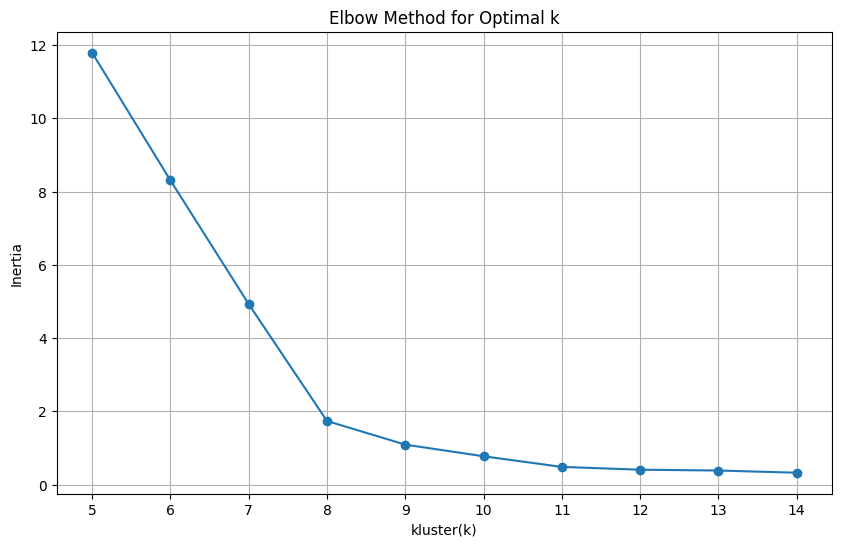

In [ ]:
# 피처 엔지니어링
pivot_data = pd.pivot_table(data2, values='is_correct', index='user_no', columns='category_no', fill_value=0)

# 엘보우 포인트 확인을 위한 코드
ks = range(5, 15)  # 클러스터 수의 범위를 조정
inertias = []

for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pivot_data)
    inertias.append(kmeans.inertia_)

# 엘보우 포인트 시각화
plt.figure(figsize=(10, 6))
plt.plot(ks, inertias, '-o')
plt.xlabel('kluster(k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(ks)
plt.grid(True)
plt.show()

In [ ]:
# K-Means 모델과 군집 예측값을 생성

# 클러스터 모델 생성 파라미터는 원할 경우 추가
clust_model = KMeans(n_clusters = 8 # 클러스터 갯수
                     ,max_iter=1000
                   , random_state = 42
                    )

# 생성한 모델로 데이터를 학습시킴
clust_model.fit(pivot_data) # unsupervised learning

# 결과 값을 변수에 저장
centers = clust_model.cluster_centers_ # 각 군집의 중심점
pred = clust_model.predict(pivot_data) # 각 예측군집

# 원래 데이터에 예측된 군집 붙이기
clust_df = pivot_data.copy()
clust_df['clust'] = pred

cluster_mean= clust_df.groupby('clust').mean()
cluster_mean

category_no,1,2,3
clust,,,
0,0.804513,0.797306,0.107752
1,0.928213,0.924683,0.938182
2,0.095953,0.087583,0.920939
3,0.069673,0.944450,0.939718
4,0.946773,0.091648,0.932108
5,0.922411,0.089677,0.070679
6,0.085027,0.082929,0.156046
7,0.093981,0.904007,0.062600


In [ ]:
X = clust_df[[1, 2, 3]]
y = clust_df['clust']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 테스트 데이터 세트에 대한 예측 및 정확도 평가
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# 새로운 사용자 데이터 예시 (가정)
new_user = pd.DataFrame([[0.9, 0.8, 0.7]], columns=[1, 2, 3])

# 새로운 사용자 데이터에 대한 군집 예측
predicted_clust = model.predict(new_user)

accuracy, predicted_clust[0]

(1.0, 1)

In [ ]:
pip install mlflow

In [ ]:
import mlflow
import mlflow.sklearn

# MLflow 추적 서버 시작 (로컬에서 실행하는 경우)
mlflow.set_tracking_uri("")    # masking addr

with mlflow.start_run():
    # 모델 학습
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # 예측 및 성능 평가
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # 매개변수, 지표 및 모델 로깅
    mlflow.log_param("random_state", 42)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.sklearn.log_model(model, "grouping_model",registered_model_name="grouping_model")

Registered model 'grouping_model' already exists. Creating a new version of this model...
2024/01/11 07:36:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: grouping_model, version 4
Created version '4' of model 'grouping_model'.


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/result_QC.csv')
data1 = data.drop(['result_no','timestamp','content','answer_no','category_no'],axis = 1)
data2 = data1.drop(data1.loc[data.category_no >=4].index,axis = 0)
data2

In [21]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np

# 데이터 로드
results_data = pd.read_csv('/content/drive/MyDrive/result_Q.csv')
questions_data = pd.read_csv('/content/drive/MyDrive/result_C.csv')

# 데이터 전처리 (필요한 특성 선택 등)
# ...

# 기계 학습 모델 선택 및 데이터 분할
X = results_data[['user_no', 'question_no']]  # 특성 선택 (사용자 번호와 문제 번호)
y = results_data['is_correct']  # 타겟 변수 (정오답 여부)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 기계 학습 모델 훈련
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 모델을 사용하여 문제 추천 생성 (예시: 사용자 123에게 추천)
user_id = 4
user_problems = results_data[results_data['user_no'] == user_id]['question_no']  # 사용자가 이미 푼 문제 가져오기
all_problems = questions_data['question_no']  # 모든 문제 가져오기
unseen_problems_data = pd.DataFrame({'user_no': [user_id] * len(unseen_problems), 'question_no': unseen_problems})
X_unseen_problems = unseen_problems_data[['user_no', 'question_no']]  # 사용자가 아직 풀지 않은 문제
unseen_problems

# # 모델을 사용하여 추천
probabilities = rf_model.predict_proba(X_unseen_problems)  # 정답 및 오답 예측 확률

# # 예측 결과 중 추천 문제 선택 (예시: 상위 3개)
# # 정답 예측 확률이 높은 순서대로 상위 3개 문제 선택
top_recommendations = unseen_problems[probabilities[:, 0].argsort()[::-1][:3]]
print(top_recommendations)

KeyError: '[1844] not in index'

In [36]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 데이터 로드
results_data = pd.read_csv('/content/drive/MyDrive/result_Q.csv')
questions_data = pd.read_csv('/content/drive/MyDrive/result_C.csv')

# 사용자별로 푼 문제 수 계산
user_problem_counts = results_data.groupby('user_no')['question_no'].count().reset_index()
user_problem_counts.columns = ['user_no', 'problem_count']

# 필요한 특성 선택
selected_results_data = results_data[['user_no', 'question_no', 'is_correct']]

# 사용자-문제 상호작용 행렬 생성
interaction_matrix = pd.pivot_table(selected_results_data, index='user_no', columns='question_no', values='is_correct', fill_value=0)

# # RandomForestClassifier를 사용하여 오답률이 높을 것으로 예측
X = interaction_matrix.values
y = user_problem_counts['problem_count'].values

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# 새로운 사용자의 문제 풀이 이력 (예시)
new_user_problems = [1, 3, 5, 7, 9]  # 새로운 사용자가 푼 문제 번호 리스트

# 모든 문제를 포함하는 0으로 초기화된 벡터 생성
all_problems = interaction_matrix.columns.tolist()
new_user_problems_vector = [1 if problem in new_user_problems else 0 for problem in all_problems]

# 사용자가 푼 문제와 유사한 문제 찾기
user_similarity = interaction_matrix.corrwith(pd.Series(new_user_problems_vector, index=interaction_matrix.columns), axis=1)
user_similarity = user_similarity.sort_values(ascending=False)

# 추천할 문제 선정 (예시: 상위 3개)
top_recommendations = []
for i, (user, similarity_score) in enumerate(user_similarity.iteritems()):
    if i == 3:  # 상위 3개만 추천
        break
    user_problems = interaction_matrix.loc[user, interaction_matrix.loc[user] == 1].index.tolist()
    for problem in user_problems:
        if problem not in new_user_problems:
            top_recommendations.append(problem)

print("Recommended Problems:", top_recommendations)

Recommended Problems: [207, 405, 613, 645, 1267, 1551, 1631, 1686, 1691, 1734, 113, 351, 592, 885, 1503, 1526, 1530, 1533, 1539, 1543, 1548, 1565, 1573, 1578, 1601, 1613, 1622, 1633, 1645, 1649, 1654, 1659, 1679, 1687, 1715, 1725, 1732, 1735, 1736, 1739, 1765, 1768, 1777, 1787, 1796, 1798, 1804, 1830, 1849, 1862, 1863, 1867, 1885, 1893, 1897, 49, 53, 79, 97, 119, 241, 256, 268, 328, 355, 361, 402, 422, 425, 488, 555, 571, 581, 596, 599, 609, 628, 634, 637, 817, 923, 976, 1031, 1109, 1114, 1117, 1129, 1153, 1156, 1201, 1305, 1370, 1374, 1395, 1564, 1627, 1677, 1682, 1715, 1799, 1823, 1904, 1917, 1928]


In [48]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

# 데이터 로드
results_data = pd.read_csv('/content/drive/MyDrive/result_Q.csv')
questions_data = pd.read_csv('/content/drive/MyDrive/result_C.csv')

# 사용자별로 푼 문제 수 계산
user_problem_counts = results_data.groupby('user_no')['question_no'].count().reset_index()
user_problem_counts.columns = ['user_no', 'problem_count']

# 필요한 특성 선택
selected_results_data = results_data[['user_no', 'question_no', 'is_correct']]

# 사용자-문제 상호작용 행렬 생성
interaction_matrix = pd.pivot_table(selected_results_data, index='user_no', columns='question_no', values='is_correct', fill_value=0)

# 문제 간 코사인 유사도 계산
cosine_sim_matrix = cosine_similarity(interaction_matrix.T)

# # TruncatedSVD를 사용한 임베딩 생성
n_components = 12  # 임베딩 차원 설정 (원하는 차원으로 조정 가능)
svd = TruncatedSVD(n_components=n_components, random_state=42)
problem_embeddings = svd.fit_transform(cosine_sim_matrix)

# # 유사한 문제 그룹화
def group_similar_problems(similarity_matrix, threshold=0.5):
    groups = {}
    for i, row in enumerate(similarity_matrix):
        similar_indices = np.where(row > threshold)[0]
        if len(similar_indices) > 0:
            groups[i] = similar_indices.tolist()
    return groups

threshold = 0.5  # 유사 문제를 그룹화하는 임계값 설정 (조정 가능)
similar_problems = group_similar_problems(cosine_sim_matrix, threshold)

# # RandomForestClassifier를 사용하여 오답률이 높을 것으로 예측
X = problem_embeddings
y = user_problem_counts['problem_count'].values
X
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(X, y)

# # 새로운 사용자의 문제 풀이 이력 (예시)
# new_user_problems = [1, 3, 5, 7, 9]  # 새로운 사용자가 푼 문제 번호 리스트

# # 사용자가 푼 문제와 유사한 문제 찾기
# user_similarity = cosine_similarity([new_user_problems], problem_embeddings)
# user_similarity = user_similarity[0]

# # 추천할 문제 선정 (예시: 상위 3개)
# top_recommendations = []
# for i, similarity_score in enumerate(user_similarity):
#     if i == 3:  # 상위 3개만 추천
#         break
#     similar_problems_indices = similar_problems[i] if i in similar_problems else []
#     for problem_idx in similar_problems_indices:
#         if problem_idx not in new_user_problems:
#             top_recommendations.append(problem_idx)

# print("Recommended Problems:", top_recommendations)

array([[ 1.04209876e+01,  1.40141556e+00,  5.23139402e+00, ...,
         1.42335996e-01, -7.76834294e-03, -1.08665745e-02],
       [ 3.36057017e+00,  1.53544831e+00, -7.70566335e-01, ...,
         2.27953258e-01,  2.02603119e+00,  4.63676479e-01],
       [ 7.54339290e+00, -4.19651241e-01,  5.30729428e+00, ...,
         3.37271807e-01,  6.23238252e-01,  9.04090664e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.11179568e-01, -3.98766502e-02, -2.92224017e-02, ...,
        -1.15610295e-01,  1.02197174e-01,  1.04655910e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])